In [1]:
import SiemensQuadraProperties as sqp
import CoincidenceGeneration as cg
import SimulationDataset as sd
import PhysicsConstants as pc
import NECRcalculation as nc
import time

import matplotlib.pyplot as plt
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "upper left",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

# Fix random seed for reproducibility, or leave blank to allow the results to vary
import numpy as np
RNG = np.random.default_rng(1234)

# Set batch size for coincidence generation
# Larger batches will use more RAM, and will eventually become inefficient due to wasted events
# Smaller batches are inefficient due to overheads
# 256-1024 seems to be about right
BATCH_SIZE=1024

Calculate NECR versus time as an F18 linear source decays from an initial 1100MBq activity (plotted activity is divided by the cylindrical phantom volume in cc).

Statistical fluctuation of the result can be reduced by increasing the simulationWindow parameter, at the cost of CPU time. The size of the simulated dataset can also be increased, but this has a lesser effect for counting experiments.

The CreateDataset command will run the Geant4 simulation with the appropriate parameters for source and detector type and length. The requested number of events will be simulated, but remember that some of these will contain no detector hits (there will be a message giving stats). If a suitable dataset already exists it will be re-used without further simulation.

In [2]:
# Note a 1e7ns simulation window (i.e. 0.01 sec) takes 200sec to simulate

def NECRatTimeF18( detectorMaterial, tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, \
                   simulationWindow=1E7, coincidenceWindow=4.7, zWindow=325.0, EnergyMin=0.0, EnergyMax=0.0 ):
 
    # Get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * np.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    truesAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    scattersAtTime = []
    randomsAtTime = []

    start = time.time_ns()

    # Perform the NECR calculation at 20 minute intervals, following NEMA standard
    for experimentTime in range( 0, 700, 20 ):
        timeSec = float(experimentTime) * 60.0

        # Assemble data sources, including crystal intrinsic background if necessary
        activityList = []
        dataList = []
        tracerActivity = pc.TracerActivityAtTime( 1100E6, timeSec, "F18" )
        if detectorMaterial == "LSO" or detectorMaterial == "LYSO":
            activityList = [tracerActivity, crystalActivity]
            dataList = [tracerData, crystalData]
        else :
            activityList = [tracerActivity]
            dataList = [tracerData]

        # Create a generator object that will simulate radioactive decays and load Geant4 events
        generator = cg.GenerateCoincidences( BATCH_SIZE, activityList, dataList, RNG, coincidenceWindow, simulationWindow, \
                                             MultiWindow=False, EnergyResolution=0.0, EnergyMin=EnergyMin, EnergyMax=EnergyMax, TimeResolution=0.0 )
        
        # Use the generator to calculate NECR and its components
        necr, Trues, Scatters, Randoms = nc.NECRfromGenerator( generator, detectorRadius, simulationWindow, \
                                                               PairMode="Exclusive", ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr*1e9 )
        truesAtTime.append( Trues*1e9 )
        scattersAtTime.append( Scatters*1e9 )
        randomsAtTime.append( Randoms*1e9 )
        activityAtTime.append( tracerActivity / phantomVolume )

    end = time.time_ns()
    print( "NECR calculation: " + str( (end-start)/1e9 ) + "s" )
    
    return activityAtTime, necrAtTime, truesAtTime, scattersAtTime, randomsAtTime

# Simulation parameters
phantomLength = 700
datasetSize = 1000000
siemensEmin = 435.0
siemensEmax = 585.0

detectorMaterial = "LSO"
tracerData = sd.CreateDataset( 1024, "Siemens", phantomLength, "LinearF18", datasetSize, siemensEmin, siemensEmax, detectorMaterial, UseNumpy=True )
crystalData = None
crystalActivity = 0.0
if detectorMaterial == "LSO" or detectorMaterial == "LYSO":
    crystalData = sd.CreateDataset( 1024, "Siemens", phantomLength, "Siemens", datasetSize, siemensEmin, siemensEmax, detectorMaterial, UseNumpy=True )
    crystalActivity = sqp.Lu176decaysInMass( sqp.DetectorMass(detectorMaterial) )

# Calculate NECR time series as the initial F18 activity decays
activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, scatterAtTimeSiemens, randomAtTimeSiemens = \
    NECRatTimeF18( detectorMaterial, tracerData, crystalData, crystalActivity, sqp.DetectorRadius(), phantomLength, \
                   EnergyMin=siemensEmin, EnergyMax=siemensEmax )

# Calculate scatter fraction defined as S/(S+T)
SFDenominatorAtTimeSiemens = [sum(n) for n in zip(trueAtTimeSiemens, scatterAtTimeSiemens)]
SFAtTimeSiemens = np.divide(scatterAtTimeSiemens, SFDenominatorAtTimeSiemens)
meanSFSiemens = np.mean(SFAtTimeSiemens)
print("Mean Scatter fraction for Siemens: ", meanSFSiemens)
plt.clf()

Re-using previous simulation
880949 events loaded (1000000 simulated) with average 1.416 hits/event
Re-using previous simulation
1000000 events loaded (1000000 simulated) with average 1.127363 hits/event
NECR calculation: 33.769062379s
Mean Scatter fraction for Siemens:  0.35201217554259845


<Figure size 640x480 with 0 Axes>

Compare the results for both Siemens Quadra and EXPLORER detectors at their default aFOV values, for a 700mm phantom.

Note that the NEMA NU 2-2012 standard specifies a 650mm window from which to accept hits

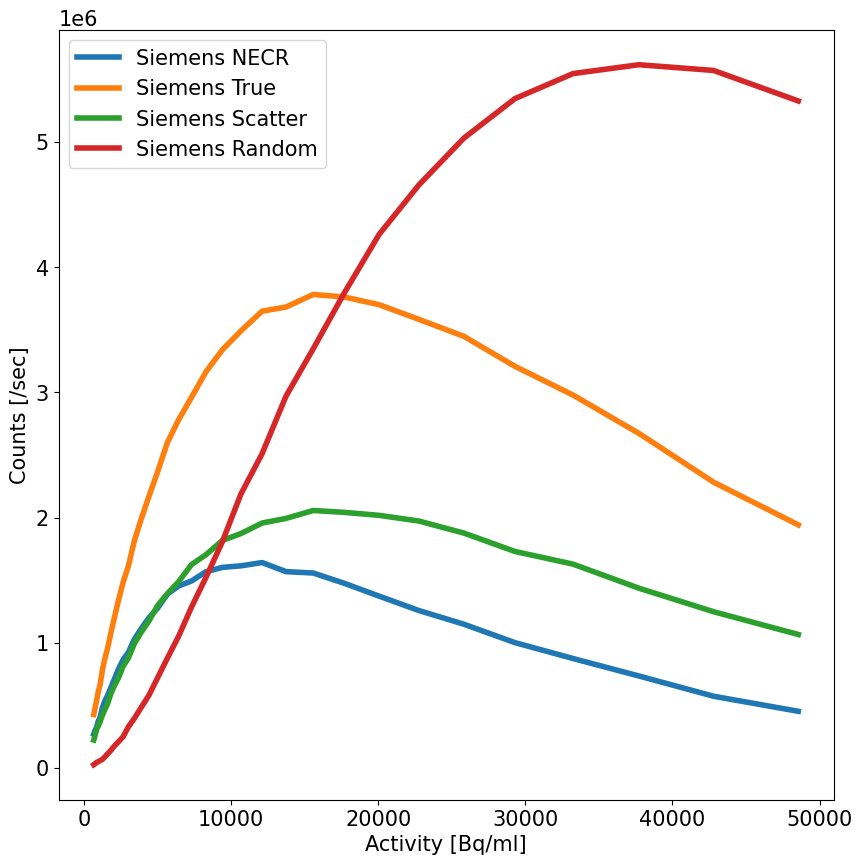

In [3]:
labels = [ "Siemens NECR", "Siemens True", "Siemens Scatter", "Siemens Random" ]
plt.plot( activityAtTimeSiemens, necrAtTimeSiemens, label=labels[0], linewidth=4.0 )
plt.plot( activityAtTimeSiemens, trueAtTimeSiemens, label=labels[1], linewidth=4.0 )
plt.plot( activityAtTimeSiemens, scatterAtTimeSiemens, label=labels[2], linewidth=4.0 )
plt.plot( activityAtTimeSiemens, randomAtTimeSiemens, label=labels[3], linewidth=4.0 )
plt.legend( labels )
plt.xlabel( "Activity [Bq/ml]" )
plt.ylabel( "Counts [/sec]" )
plt.gcf().set_size_inches(10, 10)
plt.show()

Use the data above to create a plot comparable with the experimental result in Figure 1B of https://jnm.snmjournals.org/content/early/2021/07/22/jnumed.121.261972

Prenosil GA, Sari H, Fürstner M, Afshar-Oromieh A, Shi K, Rominger A, Hentschel M. Performance Characteristics of the Biograph Vision Quadra PET/CT System with a Long Axial Field of View Using the NEMA NU 2-2018 Standard. Journal of nuclear medicine. 2022 Mar 1;63(3):476-84.

Again the experimental and simulated figures are roughly comparable, but the simulated curves peak earlier than those in the experimental results, and at notably lower values. The simulation also does not reproduce the discontinuity at ~27kBq/ml shown experimentally - this is likely due to readout dead time as a feature of the detector electronic design, which is not accounted for in this simple model.

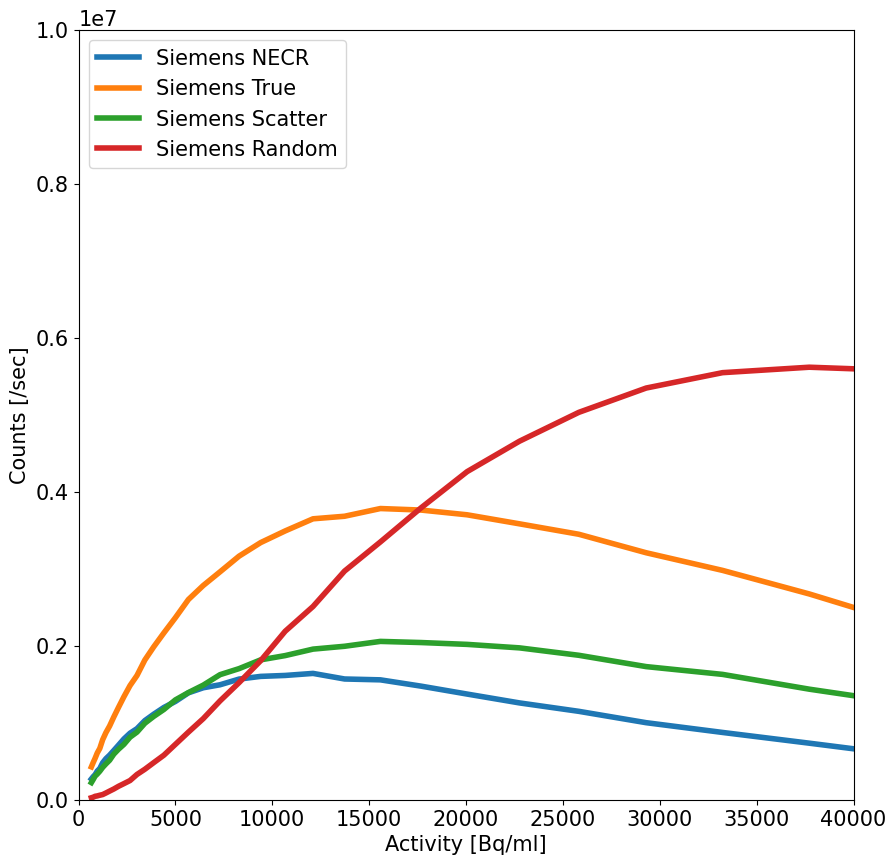

In [4]:
plt.plot( activityAtTimeSiemens, necrAtTimeSiemens, label=labels[0], linewidth=4.0 )
plt.plot( activityAtTimeSiemens, trueAtTimeSiemens, label=labels[1], linewidth=4.0 )
plt.plot( activityAtTimeSiemens, scatterAtTimeSiemens, label=labels[2], linewidth=4.0 )
plt.plot( activityAtTimeSiemens, randomAtTimeSiemens, label=labels[3], linewidth=4.0 )
plt.legend( labels )
plt.xlabel( "Activity [Bq/ml]" )
plt.xlim( [ 0, 40000 ] )
plt.ylim( [ 0, 10000000 ] )
plt.ylabel( "Counts [/sec]" )
plt.gcf().set_size_inches(10, 10)
plt.show()

Clearly the simulation can give value estimates that are reasonable, but far from an exact recreation of experimental data. Given the simplified detector geometry, data readout, and analysis methods, this is to be expected

Most importantly, the simulation is a self-consistent environment to assess the relative (rather than absolute) performance of different detectors.